# Evaluating Multiple Models for IGA
by Frank M Gonzales, P.E.

##  Introduction

The purpose of this notebook is to compare the performance of machine learning models that produce electric load forecasts for the IGA demonstration location *Kimball Substation*.  We use SCADA, Weather, & Econometric data for nine circuits to fit and evaluate the following models:

1. A ARIMA Model with Regressors (AutoRegressive Integraged Moving Average)
1. A Exponential Smoothing State Space Model
1. A Neural Network model
1. A TBATS Model (Exp. smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components)
1. A BATS model (Exp. smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components)
1. A STL Model (Seasonally adjusted)
1. A STS Model (Structural Time Series)
1. A Naive Model
1. A linear model using all variables
1. A linear model after variable selection
1. A Gradient Boosting Machine (GBM) model 
1. A General Additive model using Prophet
1. A TensorFlow RNN Model



## Outline

- [Introduction](#Introduction)
- [Prepare Data](#Prepare-Data)
- [Fit Models](#Fit-Models)
   - [Linear Model](#Linear-Model)
   - [Linear Model with Feature Selection](#Linear-Model-with-Feature-Selection)
   - [Gradient Boosting Machine Regression Model](#Gradient-Boosting-Machine-Regression-Model)
- [Conclusion](#Conclusion)

## Prepare Data

We'll start by loading the `iga` data:

In [1]:
library(tidyverse)
library(lubridate)
library(ggplot2)
library(gbm)


Warning message:
"package 'tidyverse' was built under R version 3.5.3"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Warning message:
"package 'readr' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'lubridate' was built under R version 3.5.3"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'gbm' was built under R version 3.5.3"Loaded gbm 2.1.5


In [8]:



setwd("~/GIT/epic-iga")

wn <- fread("data/wn_station.csv")
head(wn)
wn.hourly <- fread("data/wn_hourly.csv")
head(wn)

wn.dt<-data.table(as.POSIXct(wn.hourly$hourly_data_date,format="%m/%d/%Y %H:%M"),
                  wn.hourly$amb_tmp_qty,
                  wn.hourly$dw_pnt_tmp_qty,
                  wn.hourly$rltv_hum_qty,
                  wn.hourly$wet_bulb_tmp_qty,
                  wn.hourly$hz_wnd_sp_qty,
                  wn.hourly$res_wnd_sp_qty,
                  wn.hourly$wnd_dir_qty,
                  wn.hourly$pk_wnd_sp_qty,
                  wn.hourly$pk_wnd_sp_time,
                  wn.hourly$wnd_dir_pksp_qty,
                  wn.hourly$solar_rdtn_qty,
                  wn.hourly$stn_br_prsur_qty,
                  wn.hourly$sl_br_prsur_qty,
                  wn.hourly$acc_prcp_qty)

names(wn.dt)<-c("reporteddttm","Temperature","Dew_Point","Relative_Humidity","WB_Temp",
                 "Hz_Wind_Speed", "Wind_Speed", "Wind_Direction", "Pk_Wind",
                 "Pk_Wind_Time", "Wind_Dir_PkSp","Solar_Radiation", "Br_Pressure",
                 "Sl_Br_Pressure", "Accum_Precip")

wn.dt.temp=xts(wn.dt$Temperature,wn.dt$reporteddttm)
dygraph(wn.dt.temp) %>% dyRangeSelector()

#--------------------------------------------------------------------------------------
# KIMBALL CIRCUIT
# CKT_NUM	CKT_NAM
# 01749	  Blackwidow
# 06666	  Fortress	
# 06451	  Hellcat		
# 09721	  Kingcobra
# 12226	  Mosquito	
# 16497	  Skytrain	
# 17862	  Tigercat	
# 18636	  Vengeance
# 19014	  Warhawk    
#--------------------------------------------------------------------------------------
scada <- fread("data/cleansed_profiles.csv")
head(scada)

scada.blackwidow <- scada %>%
  filter(power_system_resourceid==as.numeric(01749))
scada.fortress <- scada %>%
  filter(power_system_resourceid==as.numeric(06666))
scada.hellcat <- scada %>%
  filter(power_system_resourceid==as.numeric(06451))
scada.kingcobra <- scada %>%
  filter(power_system_resourceid==as.numeric(09721))
scada.mosquito <- scada %>%
  filter(power_system_resourceid==as.numeric(12226))
scada.skytrain <- scada %>%
  filter(power_system_resourceid==as.numeric(16497))
scada.tigercat <- scada %>%
  filter(power_system_resourceid==as.numeric(17862))
scada.vengeance <- scada %>%
  filter(power_system_resourceid==as.numeric(18636))
scada.warhawk <- scada %>%
  filter(power_system_resourceid==as.numeric(19014))

#=========================================================================
scada.warhawk.kw<- scada.warhawk %>% filter(unit=="KW")
scada.warhawk.kw<- mutate (
  scada.warhawk.kw,
  reporteddttm= as.POSIXct(scada.warhawk.kw$interval_time,format="%Y-%m-%d %H:%M:%OS") # parse date column using lubridate ymd_hms function
)
setorder(scada.warhawk.kw,reporteddttm)
scada.warhawk.kw<-na.omit(scada.warhawk.kw, cols=seq_along(scada.warhawk.kw), invert=FALSE)
scada.warhawk.kw<-as.data.table(scada.warhawk.kw)
setkey(scada.warhawk.kw, "reporteddttm")
unique(scada.warhawk.kw)

#graph kw
#dygraph(xts(scada.warhawk.kw$value,scada.warhawk.kw$reporteddttm)) %>% dyRangeSelector()
#=========================================================================
scada.vengeance.kw<- scada.vengeance %>% filter(unit=="KW")
scada.vengeance.kw<- mutate (
  scada.vengeance.kw,
  reporteddttm = as.POSIXct(scada.vengeance.kw$interval_time,format="%Y-%m-%d %H:%M:%OS"))

setorder(scada.vengeance.kw,reporteddttm)
scada.vengeance.kw<-na.omit(scada.vengeance.kw, cols=seq_along(scada.vengeance.kw), invert=FALSE)
scada.vengeance.kw<-as.data.table(scada.vengeance.kw)
setkey(scada.vengeance.kw, "reporteddttm")
unique(scada.vengeance.kw)

#dygraph(xts(scada.vengeance.kw$value,scada.vengeance.kw$reporteddttm)) %>% dyRangeSelector()
#=========================================================================
scada.tigercat.kw<- scada.tigercat %>% filter(unit=="KW")
scada.tigercat.kw<- mutate (
  scada.tigercat.kw,
  reporteddttm = as.POSIXct(scada.tigercat.kw$interval_time,format="%Y-%m-%d %H:%M:%OS"))

setorder(scada.tigercat.kw,reporteddttm)
scada.tigercat.kw<-na.omit(scada.tigercat.kw, cols=seq_along(scada.tigercat.kw), invert=FALSE)
scada.tigercat.kw<-as.data.table(scada.tigercat.kw)
setkey(scada.tigercat.kw, "reporteddttm")
unique(scada.tigercat.kw)

#dygraph(xts(scada.tigercat.kw$value,scada.tigercat.kw$reporteddttm)) %>% dyRangeSelector()
#=========================================================================
scada.skytrain.kw<- scada.skytrain %>% filter(unit=="KW")
scada.skytrain.kw<- mutate (
  scada.skytrain.kw,
  reporteddttm = as.POSIXct(scada.skytrain.kw$interval_time,format="%Y-%m-%d %H:%M:%OS"))

setorder(scada.skytrain.kw,reporteddttm)
scada.skytrain.kw<-na.omit(scada.skytrain.kw, cols=seq_along(scada.skytrain.kw), invert=FALSE)
scada.skytrain.kw<-as.data.table(scada.skytrain.kw)
setkey(scada.skytrain.kw, "reporteddttm")
unique(scada.skytrain.kw)

#dygraph(xts(scada.skytrain.kw$value,scada.skytrain.kw$reporteddttm)) %>% dyRangeSelector()
#=========================================================================
scada.mosquito.kw<- scada.mosquito %>% filter(unit=="KW")
scada.mosquito.kw<- mutate (
  scada.mosquito.kw,
  reporteddttm = as.POSIXct(scada.mosquito.kw$interval_time,format="%Y-%m-%d %H:%M:%OS"))

setorder(scada.mosquito.kw,reporteddttm)
scada.mosquito.kw<-na.omit(scada.mosquito.kw, cols=seq_along(scada.mosquito.kw), invert=FALSE)
scada.mosquito.kw<-as.data.table(scada.mosquito.kw)
setkey(scada.mosquito.kw, "reporteddttm")
unique(scada.mosquito.kw)

#dygraph(xts(scada.mosquito.kw$value,scada.mosquito.kw$reporteddttm)) %>% dyRangeSelector()
#=========================================================================
scada.kingcobra.kw<- scada.kingcobra %>% filter(unit=="KW")
scada.kingcobra.kw<- mutate (
  scada.kingcobra.kw,
  reporteddttm = as.POSIXct(scada.kingcobra.kw$interval_time,format="%Y-%m-%d %H:%M:%OS"))

setorder(scada.kingcobra.kw,reporteddttm)
scada.kingcobra.kw<-na.omit(scada.kingcobra.kw, cols=seq_along(scada.kingcobra.kw), invert=FALSE)
scada.kingcobra.kw<-as.data.table(scada.kingcobra.kw)
setkey(scada.kingcobra.kw, "reporteddttm")
unique(scada.kingcobra.kw)

#dygraph(xts(scada.kingcobra.kw$value,scada.kingcobra.kw$reporteddttm)) %>% dyRangeSelector()
#=========================================================================
scada.hellcat.kw<- scada.hellcat %>% filter(unit=="KW")
scada.hellcat.kw<- mutate (
  scada.hellcat.kw,
  reporteddttm = as.POSIXct(scada.hellcat.kw$interval_time,format="%Y-%m-%d %H:%M:%OS"))

setorder(scada.hellcat.kw,reporteddttm)
scada.hellcat.kw<-na.omit(scada.hellcat.kw, cols=seq_along(scada.hellcat.kw), invert=FALSE)
scada.hellcat.kw<-as.data.table(scada.hellcat.kw)
setkey(scada.hellcat.kw, "reporteddttm")
unique(scada.hellcat.kw)

#dygraph(xts(scada.hellcat.kw$value,scada.hellcat.kw$reporteddttm)) %>% dyRangeSelector()
#=========================================================================
scada.fortress.kw<- scada.fortress %>% filter(unit=="KW")
scada.fortress.kw<- mutate (
  scada.fortress.kw,
  reporteddttm = as.POSIXct(scada.fortress.kw$interval_time,format="%Y-%m-%d %H:%M:%OS"))

setorder(scada.fortress.kw,reporteddttm)
scada.fortress.kw<-na.omit(scada.fortress.kw, cols=seq_along(scada.fortress.kw), invert=FALSE)
scada.fortress.kw<-as.data.table(scada.fortress.kw)
setkey(scada.fortress.kw, "reporteddttm")
unique(scada.fortress.kw)

#dygraph(xts(scada.fortress.kw$value,scada.fortress.kw$reporteddttm), main = "Fortress SCADA (kW)") %>% dyRangeSelector()
#=========================================================================
scada.blackwidow.kw<- scada.blackwidow %>% filter(unit=="KW")
scada.blackwidow.kw<- mutate (
  scada.blackwidow.kw,
  reporteddttm = as.POSIXct(scada.blackwidow.kw$interval_time,format="%Y-%m-%d %H:%M:%OS"))

setorder(scada.blackwidow.kw,reporteddttm)
scada.blackwidow.kw<-na.omit(scada.blackwidow.kw, cols=seq_along(scada.blackwidow.kw), invert=FALSE)
scada.blackwidow.kw<-as.data.table(scada.blackwidow.kw)
setkey(scada.blackwidow.kw, "reporteddttm")
unique(scada.blackwidow.kw)
library(readr)
wn <- read_csv("~/GIT/epic-iga/data/weatherNet_hourly.csv")
data(wn)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v ggplot2 3.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


ERROR: Error in library(gridExtra): there is no package called 'gridExtra'


In [2]:
iga_blackwidow <- read_csv("~/GIT/epic-iga/data/final/iga.blackwidow.csv")
iga_fortress <- read_csv("~/GIT/epic-iga/data/final/iga.fortress.csv")
iga_hellcat <- read_csv("~/GIT/epic-iga/data/final/iga.hellcat.csv")
iga_kingcobra <- read_csv("~/GIT/epic-iga/data/final/iga.kingcobra.csv")
iga_mosquito <- read_csv("~/GIT/epic-iga/data/final/iga.mosquito.csv")
iga_skytrain <- read_csv("~/GIT/epic-iga/data/final/iga.skytrain.csv")
iga_tigercat <- read_csv("~/GIT/epic-iga/data/final/iga.tigercat.csv")
iga_vengeance <- read_csv("~/GIT/epic-iga/data/final/iga.vengeance.csv")
iga_warhawk <- read_csv("~/GIT/epic-iga/data/final/iga.warhawk.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  unit = col_character(),
  interval_time = col_datetime(format = ""),
  batch_time = col_datetime(format = ""),
  node_key = col_character(),
  reporteddttm = col_datetime(format = "")
)
See spec(...) for full column specifications.
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  unit = col_character(),
  interval_time = col_datetime(format = ""),
  batch_time = col_datetime(format = ""),
  node_key = col_character(),
  reporteddttm = col_datetime(format = "")
)
See spec(...) for full column specifications.
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  unit = col_character(),
  interval_time = col_datetime(format = ""),
  batch_time = col_datetime(format = ""),
  node_key = col_character(),
  reportedd

There are sixteen features included in the dataset:
1. `amb_tmp_qty`, ambient temperature
1. `dw_pnt_tmp_qty`, dew point
1. `rltv_hum_qty`, relative humidity
1. `wet_bulb_tmp_qty`, wet bulb temperature
1. `hz_wnd_sp_qty`, hi-wind speed
1. `res_wnd_sp_qty`, wind speed
1. `wnd_dir_qty`, wind direction
1. `pk_wnd_sp_qty`, peak wind speed
1. `pk_wnd_sp_time`, peak wind speed time
1. `wnd_dir_pksp_qty`, peak wind speed direction
1. `solar_rdtn_qty`, solar radiation
1. `stn_br_prsur_qty`, station barometric pressure
1. `sl_br_prsur_qty`, barometric pressure
1. `acc_prcp_qty`, accumulated precipitation

A summary of their distributions and the first few records are shown below:

In [17]:
summary(iga_fortress)
head(iga_fortress)

       X1        power_system_resourceid     value             unit          
 Min.   :    1   Min.   :6666            Min.   :  371.7   Length:70038      
 1st Qu.:17510   1st Qu.:6666            1st Qu.: 2354.1   Class :character  
 Median :35020   Median :6666            Median : 2891.1   Mode  :character  
 Mean   :35020   Mean   :6666            Mean   : 3164.9                     
 3rd Qu.:52529   3rd Qu.:6666            3rd Qu.: 3696.4                     
 Max.   :70038   Max.   :6666            Max.   :12307.6                     
 interval_time                   batch_time                    node_key        
 Min.   :2011-01-01 01:00:00   Min.   :2018-08-18 13:40:11   Length:70038      
 1st Qu.:2013-01-27 04:15:00   1st Qu.:2018-08-18 13:41:13   Class :character  
 Median :2015-01-18 00:00:00   Median :2018-08-18 13:41:15   Mode  :character  
 Mean   :2014-12-29 07:24:08   Mean   :2018-08-28 00:10:17                     
 3rd Qu.:2016-12-03 13:00:00   3rd Qu.:2018-08-18 13:4

X1,power_system_resourceid,value,unit,interval_time,batch_time,node_key,year,reporteddttm,Temperature,⋯,Hz_Wind_Speed,Wind_Speed,Wind_Direction,Pk_Wind,Pk_Wind_Time,Wind_Dir_PkSp,Solar_Radiation,Br_Pressure,Sl_Br_Pressure,Accum_Precip
1,6666,2447.070,KW,2011-01-01 01:00:00,2018-08-18 13:40:11,CKT_4413_06666,2011,2011-01-01 01:00:00,43.24,,3.561,3.395,87.1,7.69,29,95.3,2.463,989.37,1021.6,0
2,6666,2447.070,KW,2011-01-01 02:00:00,2018-08-18 13:40:11,CKT_4413_06666,2011,2011-01-01 02:00:00,41.75,,4.063,3.865,81.4,8.57,117,90.1,2.533,989.55,1021.8,0
3,6666,2447.070,KW,2011-01-01 03:00:00,2018-08-18 13:40:11,CKT_4413_06666,2011,2011-01-01 03:00:00,40.26,,3.830,3.661,79.3,8.79,201,85.5,2.503,989.76,1022.0,0
4,6666,2447.070,KW,2011-01-01 04:00:00,2018-08-18 13:40:11,CKT_4413_06666,2011,2011-01-01 04:00:00,39.61,,3.941,3.762,82.7,8.35,357,96.9,2.489,989.86,1022.1,0
5,6666,2416.094,KW,2011-01-01 05:00:00,2018-08-18 13:40:11,CKT_4413_06666,2011,2011-01-01 05:00:00,39.66,,4.457,4.267,85.5,10.77,407,84.2,2.475,989.99,1022.2,0
6,6666,1497.152,KW,2011-01-01 07:00:00,2018-08-18 13:40:11,CKT_4413_06666,2011,2011-01-01 07:00:00,38.53,,4.123,3.926,84.1,9.67,656,79.7,3.329,990.93,1023.2,0


The goal for the machine learning models is to predict the load (`value`) for each circuit based on the features.

We will split the records into training and test datasets: each model will be fitted using the training data, and evaluated using the withheld test data.

In [3]:
set.seed(123)
iga_fortress.train_indices <- sample(1:nrow(iga_fortress), size = round(nrow(iga_fortress) * 0.7))
iga_fortress.train_df <- iga_fortress[iga_fortress.train_indices, ]
iga_fortress.test_df <- iga_fortress[-iga_fortress.train_indices, ]

#TODO REPEAT FOR OTHERS


As you can see from the description above, the number of predictive features available in this dataset (10) is comparable to the number of records (22). Such conditions tend to produce overfitted models that give exceptional predictions on their own training data, but poor predictions on the withheld test data. We will see an example of an overfitted model below.

## Fit Models
### Linear Model
The following lines of code fit a linear model (without regularization) using all of the original features:

In [4]:
iga_fortress.my_formula <- as.formula(paste(list(colnames(iga_fortress)[3], paste(colnames(iga_fortress)[10:15], collapse =' + ')), collapse=' ~ '))
print(iga_fortress.my_formula)

iga_fortress.fit <- lm(iga_fortress.my_formula, data=iga_fortress.train_df)
summary(iga_fortress.fit)

value ~ Temperature + Dew_Point + Relative_Humidity + WB_Temp + 
    Hz_Wind_Speed + Wind_Speed



Call:
lm(formula = iga_fortress.my_formula, data = iga_fortress.train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3474.2  -715.1  -139.6   583.6  7137.4 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        427.4956    70.7647   6.041 1.54e-09 ***
Temperature        134.1739     3.2031  41.889  < 2e-16 ***
Dew_Point           68.7229     2.0005  34.353  < 2e-16 ***
Relative_Humidity    4.4441     0.7898   5.627 1.85e-08 ***
WB_Temp           -169.4455     5.6941 -29.758  < 2e-16 ***
Hz_Wind_Speed     -311.8049    11.3151 -27.556  < 2e-16 ***
Wind_Speed         332.4629    11.3706  29.239  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1076 on 49020 degrees of freedom
Multiple R-squared:  0.2819,	Adjusted R-squared:  0.2818 
F-statistic:  3207 on 6 and 49020 DF,  p-value: < 2.2e-16


The fitted model summary shows a poor fit to the training data, but only a few of the model features have strong significance. Let's apply this fitted model to the test dataset and evaluate the results:

In [5]:
# Create a summary stats function we'll apply for each model
summary_stats <- function(predicted, actual) {
    r_squared <- 1 - (sum((actual - predicted)^2) / sum((actual - mean(actual))^2))
    mae <- mean(abs(predicted - actual))
    rmse <- (mean((predicted - actual)^2))^0.5
    rae <- mean(abs(predicted - actual)) / mean(abs(actual - mean(actual)))
    rse <- mean((predicted - actual)^2) / mean((actual - mean(actual))^2) 
    return(c(r_squared, mae, rmse, rae, rse))
}

iga_fortress.summary_df <- data.frame(list(summary_stats(predict(iga_fortress.fit, newdata=iga_fortress.test_df), iga_fortress.test_df[['value']])))
colnames(iga_fortress.summary_df) = c('Linear regression, all variables')
row.names(iga_fortress.summary_df) <- c('R-Squared', 'Mean Absolute Error', 'Root Mean Squared Error',
                           'Relative Absolute Error', 'Relative Squared Error')
iga_fortress.summary_df

,"Linear regression, all variables"
R-Squared,0.2839152
Mean Absolute Error,827.7554180
Root Mean Squared Error,1081.5901282
Relative Absolute Error,0.8742148
Relative Squared Error,0.7160848


Notice that the R-squared value for true vs. predicted `scada value` of the test set is not much better than it was for the training set. (Granted, our test set is not very large, so some fluctuation is expected.) Training R squared values that are much lower than test R squared values is indicative of model overfitting.

### Linear Model with Feature Selection

One way to reduce overfitting is to remove some predictive features from the model. Ideally we would be able to examine many or all possible subsets of features and select the subset of features that gives the best performance, but that is usually impractical due to the large number of possible subsets. A common alternative is to start from the full list of features and recursively remove one that seems to be contributing least to the model's performance (i.e., the feature whose removal has the least negative/most positive effect on model performance). This process is called recursive feature elimination (RFE).

RFE fits many models and compares their performance: it therefore requires both training and testing data. We would like to reserve the test dataset we created earlier to fairly compare all models, so RFE will need to set aside some records in the training dataset for its own round of testing. Fortunately, this is easily done using the `caret` package in R. This package will take a moment to install.

In [8]:
#install.packages('caret')
library('caret')
library('plyr')

# split the features from the field to be predicted; normalize the features
iga_fortress.x <- as.matrix(subset(iga_fortress.train_df, select =-c(1,2,3,4,5,6,7,8,9,20,21,22,23)))
iga_fortress.normalization <- preProcess(iga_fortress.x)  # train the normalizer
iga_fortress.x <- predict(iga_fortress.normalization, iga_fortress.x)  # apply the normalizer
iga_fortress.x <- as.data.frame(iga_fortress.x)
iga_fortress.y <- iga_fortress.train_df[['value']]

# perform the recursive feature elimination
set.seed(123)
ctrl <- rfeControl(functions = lmFuncs,
                   method = "repeatedcv",
                   repeats = 5)
iga_fortress.lm_rfe_results <- rfe(iga_fortress.x, iga_fortress.y,
                      sizes = c(1:9),
                      metric = 'Rsquared',
                      rfeControl = rfeControl(functions = lmFuncs,
                                              method = "repeatedcv",
                                              repeats = 5))
iga_fortress.lm_rfe_results


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables RMSE Rsquared   MAE RMSESD RsquaredSD  MAESD Selected
         1 1103   0.2440 840.7  12.21   0.009022  7.675         
         2 1099   0.2499 843.2  12.19   0.008482  7.624         
         3 1085   0.2689 830.3  12.02   0.009669  7.849         
         4 1084   0.2701 828.9  12.01   0.009747  7.678         
         5 1066   0.2947 817.5  21.48   0.022541 15.550         
         6 1033   0.3378 793.5  12.00   0.008618  8.074         
         7 1031   0.3399 792.5  11.89   0.008560  8.053         
         8 1030   0.3416 792.5  11.67   0.008715  8.003         
         9 1028   0.3440 791.1  11.72   0.008544  8.156         
        10 1028   0.3440 791.0  11.73   0.008531  8.159        *

The top 5 variables (out of 10):
   Temperature, WB_Temp, Dew_Point, Wind_Speed, Hz_Wind_Speed


We've used the R-squared value as our metric for model quality. The R-squared value is maximized when the model contains 10 features (this maximum is more easily identified in the plot below):

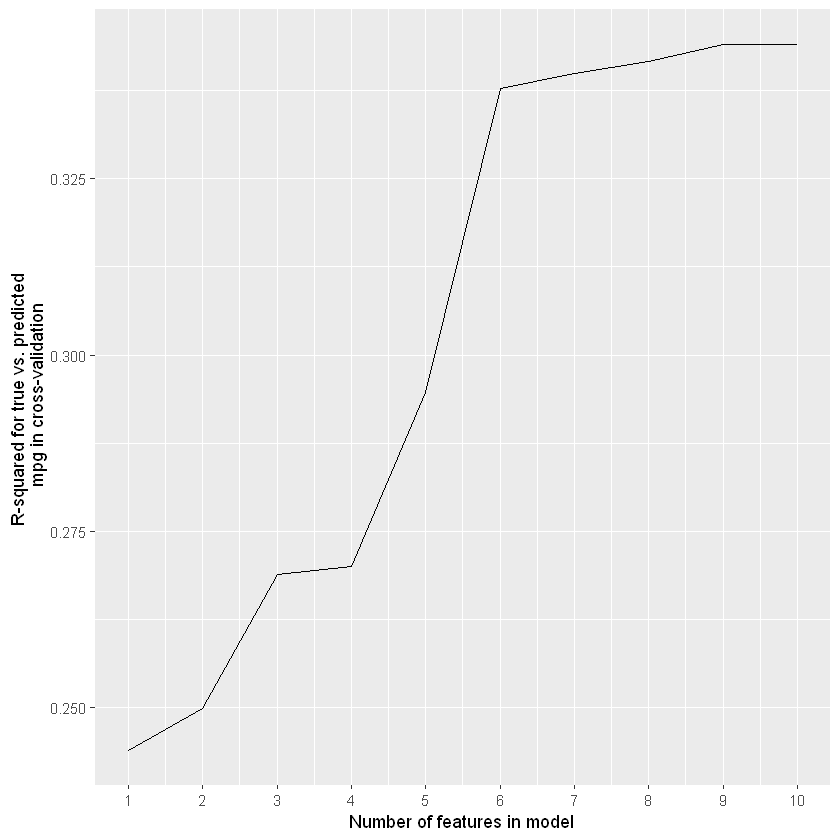

In [9]:
library(ggplot2)

plot_df = data.frame(list(Features = iga_fortress.lm_rfe_results$results$Variables,
                          Rsquared = iga_fortress.lm_rfe_results$results$Rsquared))
ggplot(plot_df, aes(x=Features, y=Rsquared)) + geom_line() +
    ylab('R-squared for true vs. predicted \n mpg in cross-validation') +
    scale_x_continuous(name = 'Number of features in model',
                       breaks=1:10)

It appears that the more features the better the performance of the model but the r squared is still relatively low.

We'll fit a linear model that uses the suggested features:

In [12]:
my_formula_short <- as.formula(paste(list(colnames(iga_fortress)[3],
                                          paste(iga_fortress.lm_rfe_results$optVariables, collapse =' + ')),
                                     collapse=' ~ '))
print(my_formula_short)
iga_fortress.fit2 <- lm(my_formula_short, data=iga_fortress.train_df)
summary(iga_fortress.fit2)

value ~ Temperature + WB_Temp + Dew_Point + Wind_Speed + Hz_Wind_Speed + 
    Pk_Wind_Time + Relative_Humidity + Pk_Wind + Wind_Direction + 
    Wind_Dir_PkSp



Call:
lm(formula = my_formula_short, data = iga_fortress.train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3375.7  -681.3  -103.8   568.2  7022.4 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -2.941e+02  6.957e+01  -4.227 2.37e-05 ***
Temperature        1.405e+02  3.075e+00  45.707  < 2e-16 ***
WB_Temp           -1.711e+02  5.506e+00 -31.078  < 2e-16 ***
Dew_Point          6.285e+01  1.924e+00  32.661  < 2e-16 ***
Wind_Speed         2.620e+02  1.154e+01  22.710  < 2e-16 ***
Hz_Wind_Speed     -1.950e+02  1.519e+01 -12.838  < 2e-16 ***
Pk_Wind_Time       4.872e-01  7.147e-03  68.176  < 2e-16 ***
Relative_Humidity  1.068e+01  7.624e-01  14.007  < 2e-16 ***
Pk_Wind           -2.903e+01  3.360e+00  -8.641  < 2e-16 ***
Wind_Direction    -8.232e-01  1.243e-01  -6.625 3.51e-11 ***
Wind_Dir_PkSp     -1.658e-01  1.179e-01  -1.406     0.16    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error

...and evaluate its performance on the test set:

In [14]:
iga_fortress.summary_df['Linear regression, selected variables'] <- summary_stats(predict(iga_fortress.fit2, iga_fortress.test_df), iga_fortress.test_df[['value']])
iga_fortress.summary_df

,"Linear regression, all variables","Linear regression, selected variables"
R-Squared,0.2839152,0.3424301
Mean Absolute Error,827.7554180,798.3755213
Root Mean Squared Error,1081.5901282,1036.4573326
Relative Absolute Error,0.8742148,0.8431859
Relative Squared Error,0.7160848,0.6575699


The model's performance on the withheld test set improved (by all metrics) after the all features were inckuded.

### Gradient Boosting Machine Regression Model

Before fitting the gradient boosting model, we need to estimate some parameters and we'll do this using cross-validation along with grid search. First, we install the necessary package for the gradient boosting machine models:

In [27]:
#install.packages('gbm')
library('gbm')

ERROR: Error in library("gbm"): there is no package called 'gbm'


We set the combinations of parameters to try using the `caret` package function `expand.grid()`, and our cross-validation settings using `trainControl`. We train the gradient boosting machine model using these parameters and the `caret` package function `train()`. This code box may take some time to run because it tries $2^4=16$ parameter combinations and runs through multiple cross-validation rounds.

In [ ]:
gbmGrid <-  expand.grid(shrinkage = c(0.01, 0.001),
                        interaction.depth = c(2, 4),
                        n.trees = c(5000, 10000),
                        n.minobsinnode = c(1, 2))
fitControl <- trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 5)
iga_fortress.fit3 <- train(iga_fortress.my_formula,
              data = iga_fortress.train_df,                
              method = "gbm",
              trControl = fitControl,
              tuneGrid = gbmGrid,
              verbose = FALSE,
              metric = 'Rsquared')
iga_fortress.fit3

We can now use the model fitted with the optimal parameter combination to predict the gas mileage for test set records:

In [12]:
iga_fortress.summary_df['Gradient boosting machine regression'] <- summary_stats(predict(iga_fortress.fit3, newdata=iga_fortress.test_df), iga_fortress.test_df[['mpg']])
iga_fortress.summary_df

,"Linear regression, all variables","Linear regression, selected variables",Gradient boosting machine regression
R-Squared,0.5538858,0.7285314,0.8295276
Mean Absolute Error,4.4714163,3.2496889,2.3240431
Root Mean Squared Error,4.8573790,3.7891239,3.0026594
Relative Absolute Error,0.7514985,0.5461662,0.3905955
Relative Squared Error,0.4461142,0.2714686,0.1704724


Looks like our gradient boosting machine model did quite well! The plot below shows the importance of each feature:

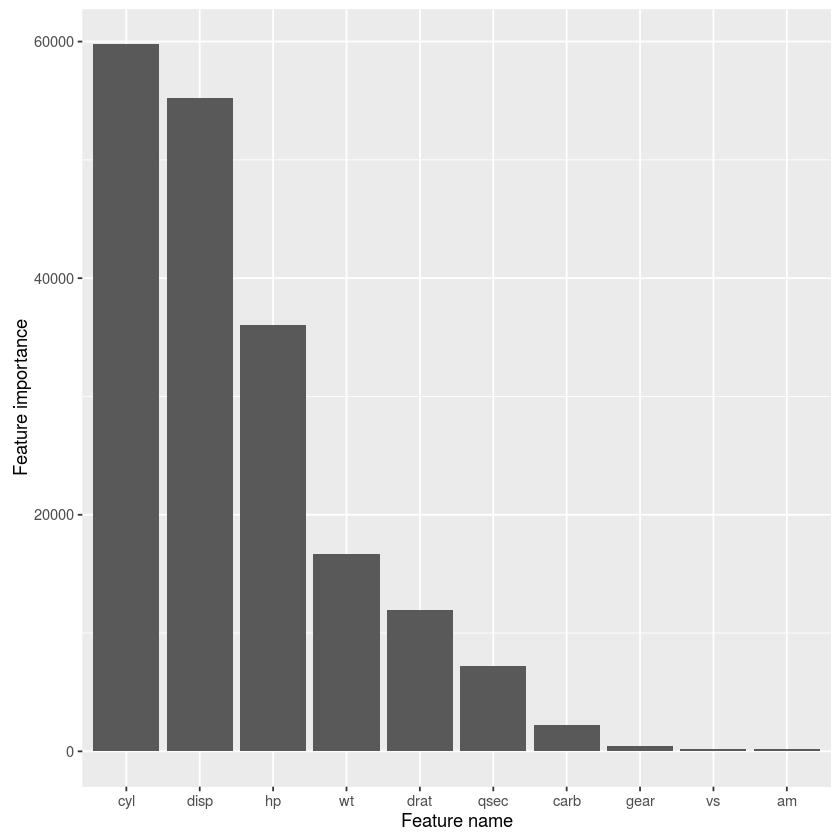

In [13]:
# get feature importance information
feature_importance <- varImp(iga_fortress.fit3, scale = FALSE)
plot_df <- data.frame(list(name = row.names(feature_importance$importance),
                           importance = feature_importance$importance$Overall))

# plot the feature importances in descending order
plot_df <- plot_df[with(plot_df, order(-importance)), ]
plot_df$name <- factor(plot_df$name, levels=plot_df$name)
ggplot(plot_df, aes(x=name, y=importance)) + geom_bar(stat='identity') +
    xlab('Feature name') + ylab('Feature importance')

Notice that the features retained after recursive feature elimination have relatively high feature importance in GBM as well.

Let's assess whether our GBM model's performance is likely to be limited by the number of estimators used:

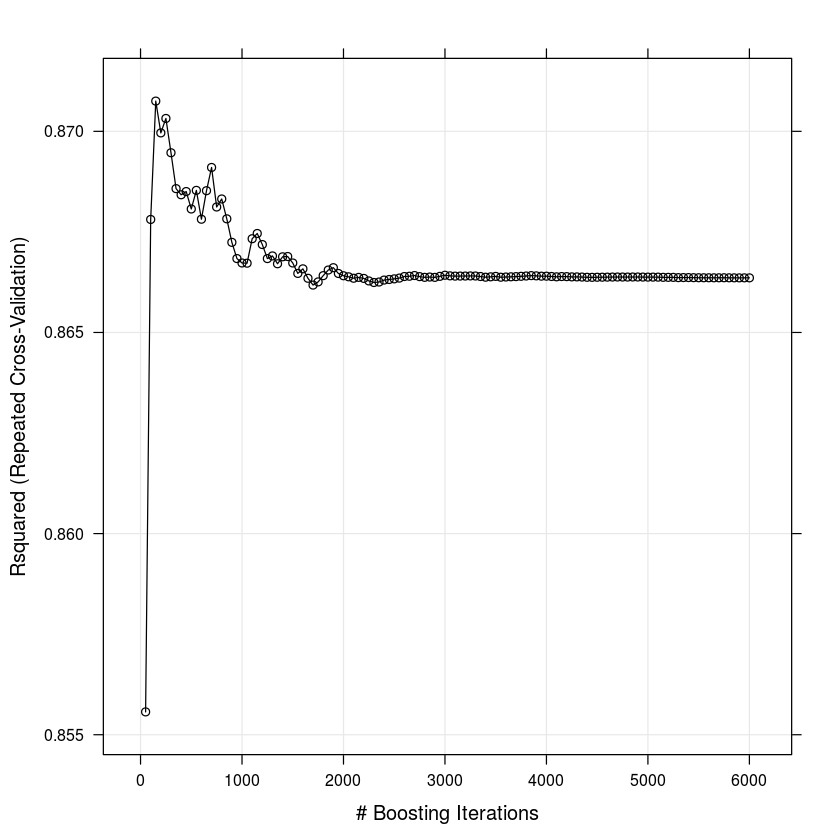

In [14]:
gbmGrid <-  expand.grid(shrinkage = 0.01,
                        interaction.depth = 2,
                        n.trees = 50 * 1:120,
                        n.minobsinnode = 1)
iga_fortress.fit3_trees <- train(iga_fortress.my_formula,
                   data = iga_fortress.train_df,                
                   method = "gbm",
                   trControl = fitControl,
                   tuneGrid = gbmGrid,
                   verbose = FALSE,
                   metric = 'Rsquared')
trellis.par.set(caretTheme())
plot(iga_fortress.fit3_trees)

The quality of the model plateaus after around 2000 iterations, suggesting that model quality would not improve substantially if the number of trees were increased.

## Conclusion
The following table compares the performance of the three models. Variable selection using RFE improved the performance of the linear regression model by all metrics. The GBM model performed better still on all metrics, though some differences are small relative to the random fluctuations we might expect with a dataset of this size.

In [15]:
iga_fortress.summary_df

,"Linear regression, all variables","Linear regression, selected variables",Gradient boosting machine regression
R-Squared,0.5538858,0.7285314,0.8295276
Mean Absolute Error,4.4714163,3.2496889,2.3240431
Root Mean Squared Error,4.8573790,3.7891239,3.0026594
Relative Absolute Error,0.7514985,0.5461662,0.3905955
Relative Squared Error,0.4461142,0.2714686,0.1704724


## RandomForest

In [ ]:
fit2 <- randomForest(sqrt(value)~inversion+wind+precip+fireworks,data=dat[!is.na(dat$pm2.5),], ntree=500)

## TBATS 
TBATS model with weekly and yearly seasonality

In [ ]:
# TBATS model with weekly and yearly seasonality
dat.ts2 <- sqrt(msts(dat[!is.na(dat$pm2.5),"pm2.5"], seasonal.periods=c(7,365.25)))
fit5 <- tbats(dat.ts2)
fc5 <- forecast(fit5,h=30)

## ARIMA 
ARIMA with weekly and yearly seasonality with regressors

In [ ]:
# ARIMA with weekly and yearly seasonality with regressors
regs <- dat[!is.na(dat$pm2.5),c("precip","wind","inversion","fireworks")]
# Forecast weather regressors
weather.ts <- msts(dat[,c("precip","wind","inversion_diff")],seasonal.periods = c(7,365.25))
precip <- auto.arima(weather.ts[,1])
fprecip <- as.numeric(data.frame(forecast(precip,h=25))$Point.Forecast)
wind <- auto.arima(weather.ts[,2])
fwind <- as.numeric(data.frame(forecast(wind,h=25))$Point.Forecast)
inversion <- auto.arima(weather.ts[,3])
finversion <- as.numeric(data.frame(forecast(inversion,h=25))$Point.Forecast)

fregs <- data.frame(precip=fprecip,wind=fwind,inversion=as.numeric(finversion<0),fireworks=0)

# Seasonality
z <- fourier(dat.ts2, K=c(2,5))
zf <- fourier(dat.ts2, K=c(2,5), h=25)

# Fit the model
fit <- auto.arima(dat.ts2, xreg=cbind(z,regs), seasonal=FALSE)

# Predict Future Values
# This time we need future values of the regressors as well.
fc <- forecast(fit, xreg=cbind(zf,fregs), h=25)

## Prophet
Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
pdat <- data.frame(ds=dat$date,
                   y=sqrt(dat$pm2.5),
                   precip=dat$precip,
                   wind=dat$wind,
                   inversion_diff=dat$inversion_diff,
                   inversion=dat$inversion_,
                   fireworks=dat$fireworks)

# Forecast weather regressors
pfdat <- data.frame(ds=max(dat$date) + 1:25)
pprecip <- pdat %>% 
  select(ds,y=precip) %>% 
  prophet() %>%
  predict(pfdat)

pwind <- pdat %>% 
  select(ds,y=wind) %>% 
  prophet() %>%
  predict(pfdat)

pinversion <- pdat %>% 
  select(ds,y=inversion_diff) %>% 
  prophet() %>%
  predict(pfdat)

fdat <-  data.frame(ds=pfdat$ds,
                    precip=pprecip$yhat,
                    wind=pwind$yhat,
                    inversion=as.numeric(pinversion$yhat<0),
                    fireworks = 0)

# Fit the model (Seasonality automatically determined)
fit6 <- prophet() %>% 
  add_regressor('precip') %>% 
  add_regressor('wind') %>% 
  add_regressor('inversion') %>% 
  add_regressor('fireworks') %>% 
  fit.prophet(pdat)

# Forecast future values
forecast <- predict(fit6, fdat)

# Get the residuals
fpred <- predict(fit6)
fpred$ds <- as.Date(fpred$ds)
fpred <- pdat %>% left_join(fpred,by="ds")
fpred$resid <- fpred$y - fpred$yhat

###########################################################################################
library(timeDate)
date.sequence <- timeSequence( min(fortress_forecast_df$ds), max(fortress_forecast_df$ds)) ;
# holidays in the period
years.included <- unique( as.integer( format( x=date.sequence, format="%Y" ) ) );
holidays <- holidayNYSE(years.included) 
# Subset business days
notbusiness.days <- date.sequence[!(isBizday(date.sequence, holidays))]; 

library(dplyr)
holiday_or_weekends <- data_frame(
  holiday = 'holiday_or_weekends',
  ds = as.Date(notbusiness.days),
lower_window = 0,
upper_window = 1
)


m <- prophet(fortress_forecast_df, holidays = holiday_or_weekends)
forecast <- predict(m, future)
forecast_plot<-plot(m, forecast)

## Comparison

In [ ]:
# RMSE by cutoff
all.cv %>% 
  group_by(model,cutoff) %>% 
  summarise(rmse=sqrt(mean((y-yhat)^2))) %>% 
  ggplot(.,aes(x=cutoff,y=rmse,group=model,color=model)) +
  geom_line(alpha=.75) + geom_point(alpha=.75)

# RMSE by horizon
all.cv %>% 
  group_by(model,day) %>% 
  summarise(rmse=sqrt(mean((y-yhat)^2))) %>% 
  ggplot(.,aes(x=day,y=rmse,group=model,color=model)) +
  geom_line(alpha=.75) + geom_point(alpha=.75)

# Prediction behaviors of different methods
ggplot(all.cv,aes(date,yhat,group=as.factor(cutoff),color=as.factor(cutoff)))+
  geom_line()+
  geom_line(aes(y=y),color="black",alpha=.15)+#geom_point(aes(y=y),color="black",alpha=.15)+
  facet_wrap(~model)+ guides(color="none") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())